In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [16]:
import os
!mkdir ~/.kaggle.
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json.
!kaggle datasets download -d ealaxi/paysim1

mkdir: cannot create directory ‘/root/.kaggle.’: File exists
chmod: cannot access '/root/.kaggle/kaggle.json.': No such file or directory
 99% 176M/178M [00:10<00:00, 21.1MB/s]
100% 178M/178M [00:10<00:00, 18.3MB/s]


In [17]:
!unzip paysim1.zip

Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [18]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [19]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [20]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [21]:
df.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

## EDA

In [22]:
df.loc[df.isFraud == 1].type.drop_duplicates().values # so only cahs out and transfers have fraudlent cases

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [23]:
dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
print(len(dfFraudTransfer)) # Number of fraud trans in transfer

4097


In [24]:
dfFraudCO = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]
print(len(dfFraudCO)) # Number of fraud trans in cash out

4116


### Something about isFlaggedFraud

So there are some cases where the isFlaggedFraud is set to 0, but the transfer amount still exceeds the threshold of 200,000

In [25]:
df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()

2736446    TRANSFER
Name: type, dtype: object

In [26]:
dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

In [27]:
dfFlagged.amount.min()

353874.22

In [28]:
dfFlagged.amount.max()

10000000.0

In [29]:
dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.min()

2.6

In [30]:
dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max()

92445516.64

Can oldBalanceDest and newBalanceDest determine isFlaggedFraud being set? The old is identical to the new balance in the origin and destination accounts, for every TRANSFER where isFlaggedFraud is set. This is presumably because the transaction is halted. Interestingly, oldBalanceDest = 0 in every such transaction. However, as shown below, since isFlaggedFraud can remain not set in TRANSFERS where oldBalanceDest and newBalanceDest can both be 0, these conditions do not determine the state of isFlaggedFraud.

In [31]:
len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & (dfTransfer.oldbalanceDest == 0) & (dfTransfer.newbalanceDest == 0)])

4158

Can isFlaggedFraud be set based on seeing a customer transacting more than once? Note that duplicate customer names don't exist within transactions where isFlaggedFraud is set, but duplicate customer names exist within transactions where isFlaggedFraud is not set. It turns out that originators of transactions that have isFlaggedFraud set have transacted only once. Very few destination accounts of transactions that have isFlaggedFraud set have transacted more than once.

In [32]:
dfFlagged.nameOrig.isin(pd.concat([dfNotFlagged.nameOrig,dfNotFlagged.nameDest])).any()

False

It can be easily seen that transactions with isFlaggedFraud set occur at all values of step, similar to the complementary set of transactions. Thus isFlaggedFraud does not correlate with step either and is therefore seemingly unrelated to any explanatory variable or feature in the data

From nameOrig and nameDest, 'M' occuring in an unexpected way

In [33]:
df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M').any()

False

In [34]:
df.loc[df.type == 'CASH_OUT'].nameOrig.str.contains('M').any()

False

### Data Cleaning

In [35]:
x = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

In [36]:
len(x)

2770409

In [37]:
y = x['isFraud']
del x['isFraud']

In [38]:
len(y)

2770409

In [39]:
x = x.drop(['nameOrig','nameDest','isFlaggedFraud'],axis = 1)

In [40]:
x.loc[x.type == 'TRANSFER','type'] = 0
x.loc[x.type == 'CASH_OUT','type'] = 1
x.type = x.type.astype(int)

In [41]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [42]:
Xfraud = x.loc[y == 1]
XnonFraud = x.loc[y == 0]

In [43]:
len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & \
(Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))

0.4955558261293072

In [44]:
len(XnonFraud.loc[(XnonFraud.oldbalanceDest == 0) & \
(XnonFraud.newbalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))

0.0006176245277308345

In [45]:
x.loc[(x.oldbalanceDest == 0) & (x.newbalanceDest == 0) & (x.amount != 0),['oldbalanceDest', 'newbalanceDest']] = - 1

In [46]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,0,215310.30,705.0,0.0,22425.0,0.00
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89


In [47]:
x.loc[(x.oldbalanceOrg == 0) & (x.newbalanceOrig == 0) & (x.amount != 0),['oldbalanceOrig', 'newbalanceOrig']] = np.nan

In [48]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,oldbalanceOrig
2,1,0,181.00,181.0,0.0,-1.0,-1.00,NaN
3,1,1,181.00,181.0,0.0,21182.0,0.00,NaN
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,NaN
19,1,0,215310.30,705.0,0.0,22425.0,0.00,NaN
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,NaN


In [49]:
x['errorBalanceOrig'] = x.newbalanceOrig + x.amount - x.oldbalanceOrg
x['errorBalanceDest'] = x.oldbalanceDest + x.amount - x.newbalanceDest

In [50]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,oldbalanceOrig,errorBalanceOrig,errorBalanceDest
2,1,0,181.00,181.0,0.0,-1.0,-1.00,NaN,0.00,181.0
3,1,1,181.00,181.0,0.0,21182.0,0.00,NaN,0.00,21363.0
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44,NaN,213808.94,182703.5
19,1,0,215310.30,705.0,0.0,22425.0,0.00,NaN,214605.30,237735.3
24,1,0,311685.89,10835.0,0.0,6267.0,2719172.89,NaN,300850.89,-2401220.0


In [51]:
len(Xfraud) / float(len(x))

0.002964544224336551

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)

In [53]:
x_train.shape, y_train.shape

((2216327, 10), (2216327,))

In [54]:
x_test.shape, y_test.shape

((554082, 10), (554082,))

In [55]:
pos_weight_scale = (y == 0).sum() / (1.0 * (y == 1).sum())

In [56]:
pos_weight_scale

336.3199805186899

In [57]:
clf = XGBClassifier(
    max_depth = 3,
    scale_pos_weight = pos_weight_scale,
    n_jobs = 4
)

In [58]:
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [60]:
proba = clf.fit(x_train,y_train).predict_proba(x_test)

In [61]:
average_precision_score(y_test,proba[:,1])

0.9971522981471486

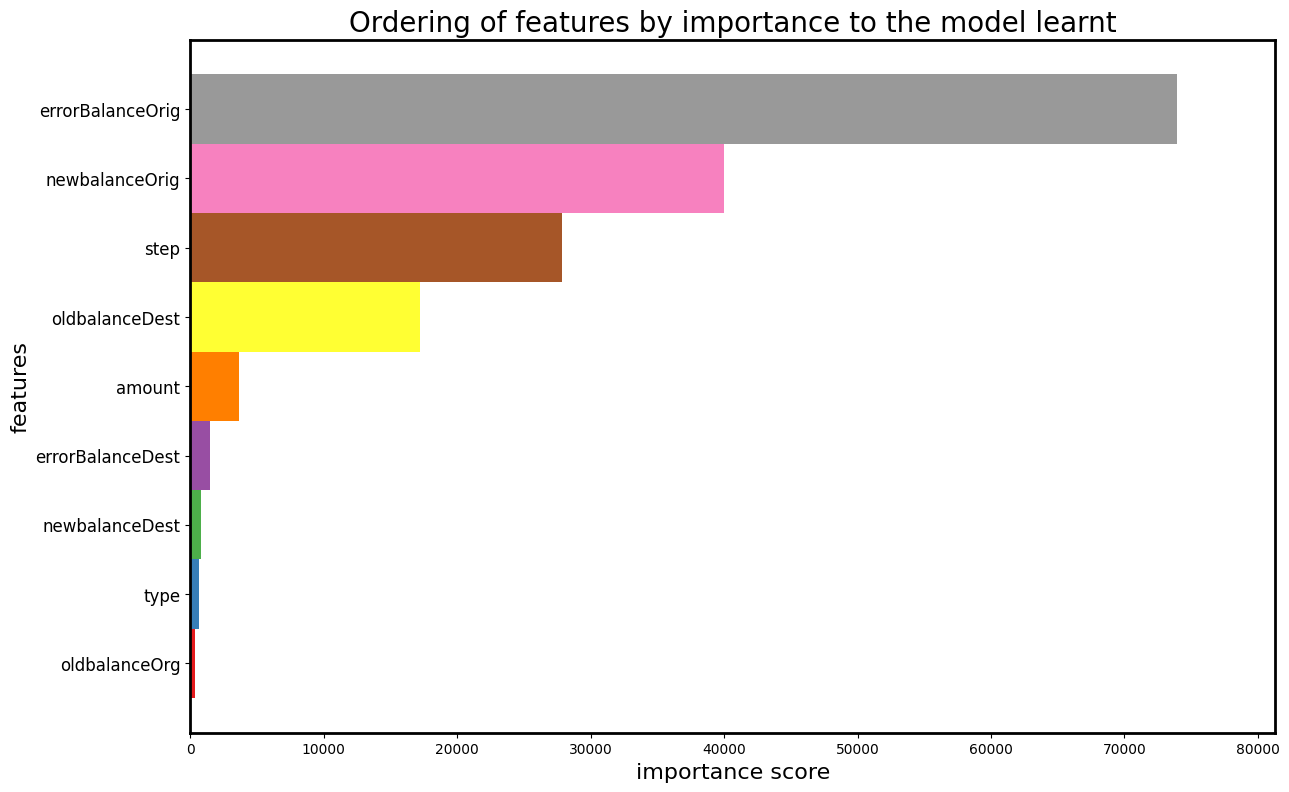

In [62]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);